In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [2]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print(f'Any nan variable : {df.isnull().values.any()}')
df.describe().T

Any nan variable : False


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

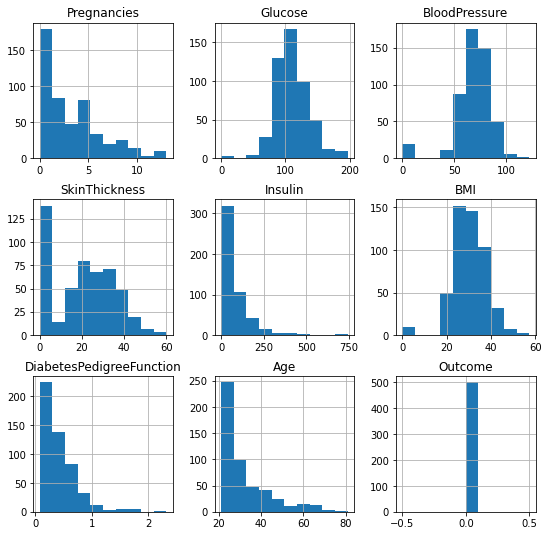

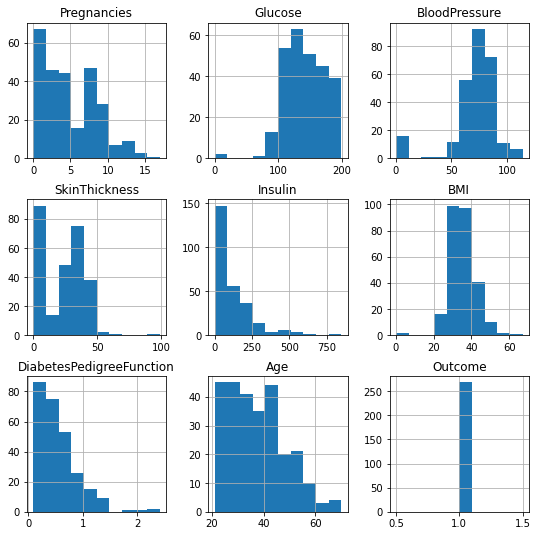

In [5]:
df.groupby('Outcome').hist(figsize=(9, 9))

In [6]:
print(f'Total num of blood pressure = 0 : {df[df.BloodPressure == 0].shape[0]}')
print(f'Total num of glucose = 0 : {df[df.Glucose == 0].shape[0]}')
print(f'Total num of bmi = 0 : {df[df.BMI == 0].shape[0]}')
print(f'Total num of skin tickness = 0 : {df[df.SkinThickness == 0].shape[0]}')
print(f'Total num of insulin = 0 : {df[df.Insulin == 0].shape[0]}')

Total num of blood pressure = 0 : 35
Total num of glucose = 0 : 5
Total num of bmi = 0 : 11
Total num of skin tickness = 0 : 227
Total num of insulin = 0 : 374


In [7]:
def find_medians(df,feature_):
    not_na = df[df[feature_].notna()]
    not_na = not_na[[feature_,'Outcome']].groupby(['Outcome'])[[feature_]].median()
    return not_na.reset_index()

## Find the median according to outcomes 

In [8]:
ins_med_1 = int(df.loc[(df.Outcome==1),'Glucose'].median())
ins_med_0 = int(df.loc[(df.Outcome==0),'Glucose'].median())

print(f'Median of Glucose (Outcome==1) : {ins_med_1}\nMedian of Glucose (Outcome==0) : {ins_med_0}')

Median of Glucose (Outcome==1) : 140
Median of Glucose (Outcome==0) : 107


In [9]:
a = find_medians(df,'Glucose')
a

,Outcome,Glucose
0,0,107
1,1,140


In [10]:
def fill_with_median(df,feature_,var0,var1):
    for c in np.arange(len(df)):
        if (df.loc[c,'Outcome'] == 0) and (df.loc[c,feature_] == 0):
            df.loc[c,feature_] = var0
        if (df.loc[c,'Outcome'] == 1) and (df.loc[c,feature_] == 0):
            df.loc[c,feature_] = var1

        #Filling zeros with medians which are according to outcomes.

In [11]:
ins = find_medians(df,'Insulin')
bp = find_medians(df,'BloodPressure')
st = find_medians(df,'SkinThickness')
gl = find_medians(df,'Glucose')
bmi = find_medians(df,'BMI')

fill_with_median(df,'Insulin',ins.loc[0,'Insulin'],ins.loc[1,'Insulin'])
fill_with_median(df,'BloodPressure',bp.loc[0,'BloodPressure'],bp.loc[1,'BloodPressure'])
fill_with_median(df,'SkinThickness',st.loc[0,'SkinThickness'],st.loc[1,'SkinThickness'])
fill_with_median(df,'Glucose',gl.loc[0,'Glucose'],gl.loc[1,'Glucose'])
fill_with_median(df,'BMI',bmi.loc[0,'BMI'],bmi.loc[1,'BMI'])


<AxesSubplot:xlabel='Outcome', ylabel='count'>

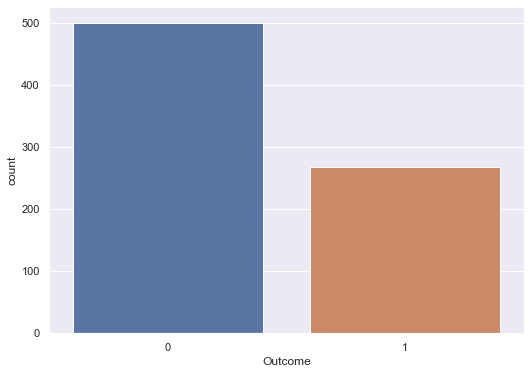

In [12]:
plt.figure(figsize=(8.5,6))
sns.set_theme()
sns.countplot(df['Outcome'])

In [13]:
def my_scatter_plot(df,varx,vary):
    sns.set_theme()
    plt.figure(figsize=(14,11))
    sns.scatterplot(x=df[varx],y=df[vary],hue=df['Outcome'])
    plt.show()

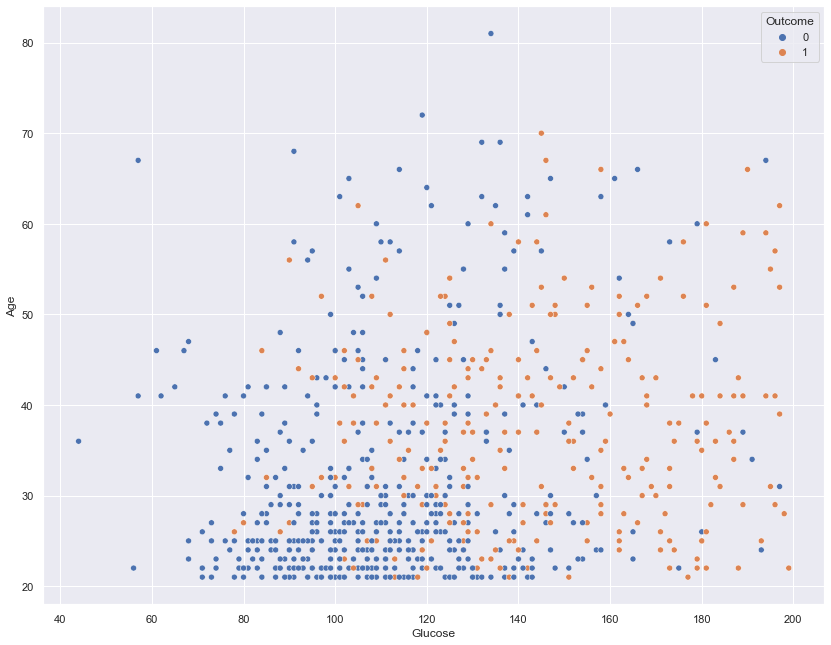

In [14]:
my_scatter_plot(df,'Glucose','Age')

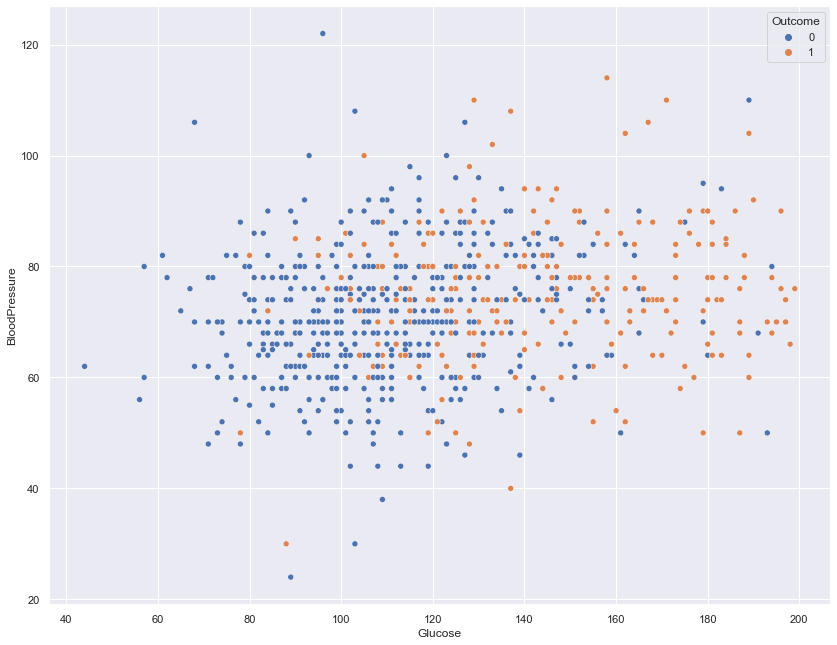

In [15]:
my_scatter_plot(df,'Glucose','BloodPressure')

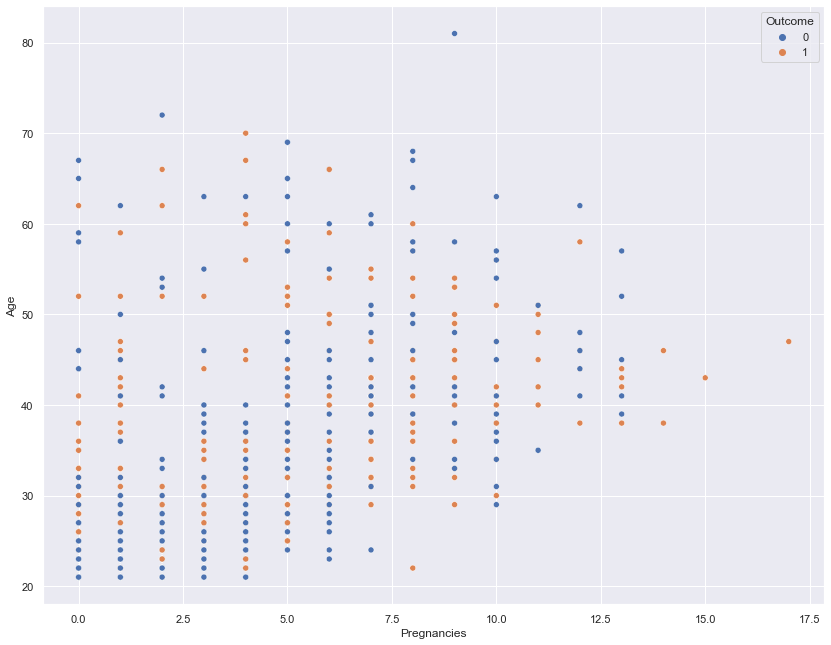

In [16]:
my_scatter_plot(df,'Pregnancies','Age')

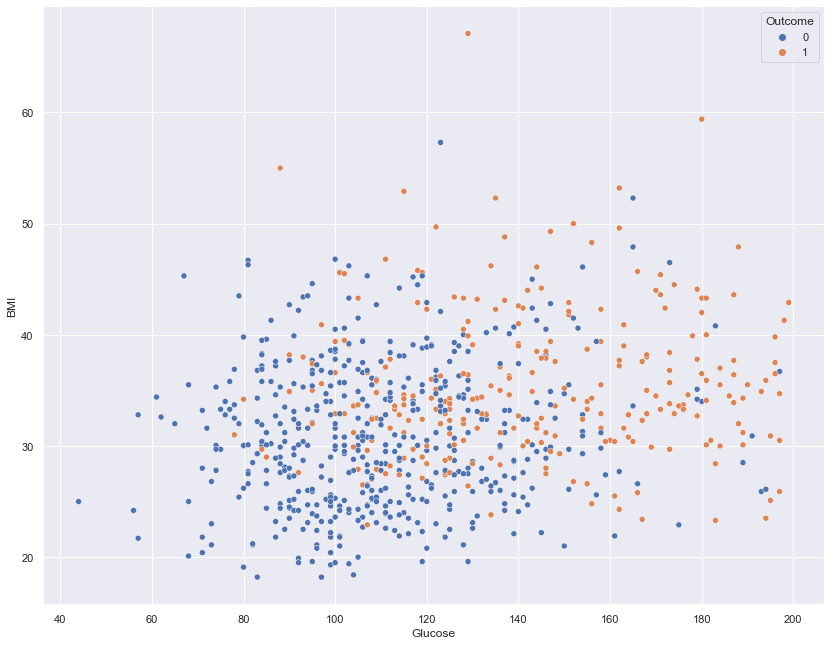

In [17]:
my_scatter_plot(df,'Glucose','BMI')

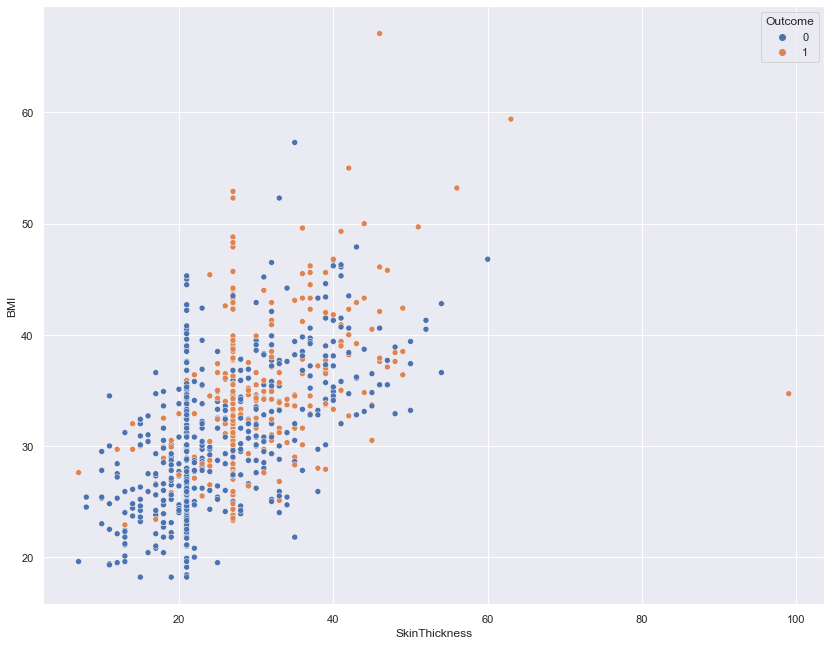

In [18]:
my_scatter_plot(df,'SkinThickness','BMI')

In [19]:
# Setting Rules according to tables above

df.loc[:,'R1'] = 1
df.loc[(df.Age<=30) & (df.Glucose<=120),'R1'] = 0
df.loc[(df.Age>30) & (df.Age<48) & (df.Glucose<=88),'R1'] = 0 
df.loc[(df.Age>64) & (df.Glucose<=142),'R1'] = 0

df.loc[:,'R2'] = 1
df.loc[(df.BMI<=30),'R2'] = 0

df.loc[:,'R3'] = 1
df.loc[(df.Age<=27) & (df.Pregnancies<=6),'R3'] = 0
df.loc[(df.Age>60) & (df.Pregnancies>7.5),'R3'] = 0

df.loc[:,'R4'] = 1
df.loc[(df.Glucose<=105) & (df.BloodPressure<=80),'R4'] = 0
df.loc[(df.Glucose<=105) & (df.BloodPressure>83),'R4'] = 0

df.loc[:,'R5'] = 1
df.loc[(df.SkinThickness<=20),'R5']=0

df.loc[:,'R6'] = 1
df.loc[(df.Glucose<=105) & (df.BMI<=30),'R6'] = 0
df.loc[(df.Glucose<=105) & (df.BMI>41),'R6'] = 0

df.loc[:,'R7'] = 1
df.loc[(df.Insulin<200),'R7'] = 0

df.loc[:,'R8'] = 1
df.loc[(df.BloodPressure<80),'R8'] = 0

df.loc[:,'R9'] = 1
df.loc[(df.BMI<30) & (df.SkinThickness<21),'R9'] = 0
df.loc[(df.BMI>33) & (df.SkinThickness<21),'R9'] = 0

df.loc[:,'R10'] = 1
df.loc[(df.Pregnancies!=0) & (df.Pregnancies<4),'R10'] = 0


In [20]:
df['R11'] = df['BMI'] * df['SkinThickness']
df['R12'] = df['Pregnancies'] / df['Age']
df['R13'] = df['Glucose'] / df['DiabetesPedigreeFunction']
df['R14'] = df['Age'] * df['DiabetesPedigreeFunction']

df.loc[:,'R15'] = 1
df.loc[(df['R11']<1034),'R15'] = 0


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.0,121.677083,30.464161,44.000000,99.750000,117.000000,140.250000,199.000000
BloodPressure,768.0,72.378906,12.104431,24.000000,64.000000,72.000000,80.000000,122.000000
SkinThickness,768.0,27.430990,9.321460,7.000000,21.000000,27.000000,32.000000,99.000000
Insulin,768.0,91.783854,108.121136,0.000000,39.000000,39.000000,127.250000,846.000000
BMI,768.0,32.433919,6.880664,18.200000,27.500000,32.050000,36.600000,67.100000
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.0,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000
R1,768.0,0.601562,0.489895,0.000000,0.000000,1.000000,1.000000,1.000000


In [22]:
x = df.drop('Outcome',axis=1)
y = df['Outcome']

In [23]:
xtrain,xtest,ytrain,ytest = train_test_split(
    x,y,test_size=0.2,random_state=42
)

print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(614, 23) (614,)
(154, 23) (154,)


In [24]:
std_scaler = StandardScaler()
xtrain_scaled = std_scaler.fit_transform(xtrain)
xtest_scaled = std_scaler.transform(xtest)

In [25]:
def plot_conf_matrix(cm):
    plt.figure(figsize=(7.5,7.5))
    sns.heatmap(cm,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [26]:
cv_kfold = KFold(n_splits=10,shuffle=True,random_state=42)
svc_model = SVC()
svc_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel' : ['rbf']
            } 
svc_grid = GridSearchCV(svc_model,
                        svc_params,
                        cv=cv_kfold,
                        verbose=3,
                        n_jobs=-1,
                        refit=True
                        )

svc_grid.fit(xtrain_scaled,ytrain)

tuned_svc = SVC(
    C=svc_grid.best_params_['C'],
    gamma=svc_grid.best_params_['gamma'],
    kernel=svc_grid.best_params_['kernel']
).fit(xtrain_scaled,ytrain)

ypred_svc = tuned_svc.predict(xtest_scaled)
svc_test_accuracy = accuracy_score(ytest,ypred_svc)
svc_train_accuracy = accuracy_score(ytrain,tuned_svc.predict(xtrain_scaled))
print(svc_test_accuracy,svc_train_accuracy)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
0.7922077922077922 0.9299674267100977


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        99
           1       0.68      0.78      0.73        55

    accuracy                           0.79       154
   macro avg       0.78      0.79      0.78       154
weighted avg       0.80      0.79      0.79       154



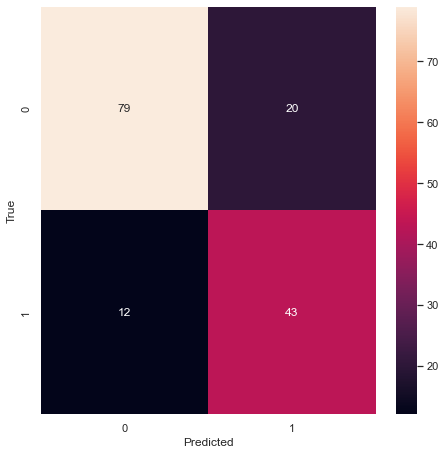

In [27]:
print(classification_report(ytest,ypred_svc))
cm_svc = confusion_matrix(ytest,ypred_svc)

plot_conf_matrix(cm_svc)



In [28]:
bagging_params = {
    'n_estimators':[200,500,700],
    'max_samples':[50,100]
}
bagging_model = BaggingClassifier(DecisionTreeClassifier(random_state=42))
bagging_grid = GridSearchCV(
    bagging_model,
    bagging_params,
    cv=cv_kfold,
    verbose=2,
    n_jobs=-1
)

bagging_grid.fit(xtrain_scaled,ytrain)

tuned_bagging = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=bagging_grid.best_params_['n_estimators'],
    max_samples=bagging_grid.best_params_['max_samples'],
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
    ).fit(xtrain_scaled,ytrain)

ypred_bag = tuned_bagging.predict(xtest_scaled)
bag_test_accuracy = accuracy_score(ytest,ypred_bag)
bag_train_accuracy = accuracy_score(ytrain,tuned_bagging.predict(xtrain_scaled))
print(bag_test_accuracy,bag_train_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.9155844155844156 0.9234527687296417


              precision    recall  f1-score   support

           0       0.91      0.96      0.94        99
           1       0.92      0.84      0.88        55

    accuracy                           0.92       154
   macro avg       0.92      0.90      0.91       154
weighted avg       0.92      0.92      0.91       154



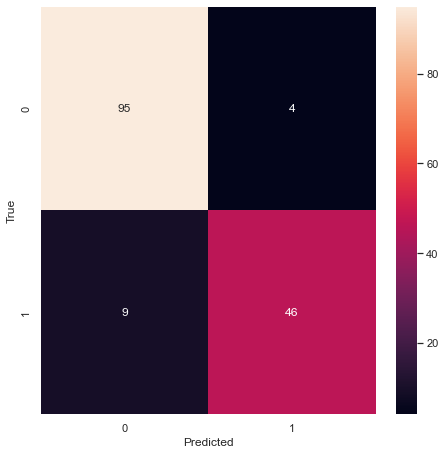

In [29]:
print(classification_report(ytest,ypred_bag))
cm_bag = confusion_matrix(ytest,ypred_bag)

plot_conf_matrix(cm_bag)

In [30]:
rf_params = { 
    'n_estimators': [200,500,700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv= cv_kfold,
    verbose=2,
    n_jobs=-1
    )


rf_grid.fit(xtrain_scaled,ytrain)

tuned_rf = RandomForestClassifier(
    n_estimators=rf_grid.best_params_['n_estimators'],
    max_features=rf_grid.best_params_['max_features'],
    oob_score=True,
    n_jobs=-1
).fit(xtrain_scaled,ytrain)

ypred_rf = tuned_rf.predict(xtest_scaled)
rf_test_accuracy = accuracy_score(ytest,ypred_rf)
rf_train_accuracy = accuracy_score(ytrain,tuned_rf.predict(xtrain_scaled))
print(rf_test_accuracy,rf_train_accuracy)



Fitting 10 folds for each of 9 candidates, totalling 90 fits
0.8766233766233766 1.0


              precision    recall  f1-score   support

           0       0.90      0.91      0.90        99
           1       0.83      0.82      0.83        55

    accuracy                           0.88       154
   macro avg       0.87      0.86      0.87       154
weighted avg       0.88      0.88      0.88       154



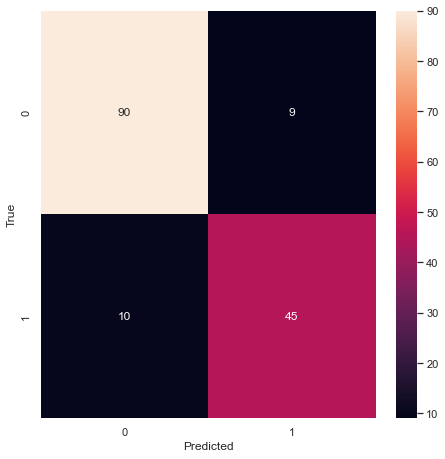

In [31]:
print(classification_report(ytest,ypred_rf))
cm_rf = confusion_matrix(ytest,ypred_rf)

plot_conf_matrix(cm_rf)

In [32]:
import lightgbm as lgbm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(x,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [3,4,5,6,7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
lgbm_grid = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

lgbm_grid.fit(x, y, **fit_params)
opt_parameters =  lgbm_grid.best_params_
tuned_lgbm = lgbm.LGBMClassifier(**opt_parameters).fit(xtrain,ytrain)

ypred_lgbm = tuned_lgbm.predict(xtest)
lgbm_test_accuracy = accuracy_score(ytest,ypred_lgbm)
lgbm_train_accuracy = accuracy_score(ytrain,tuned_lgbm.predict(xtrain))
print(lgbm_test_accuracy,lgbm_train_accuracy)



Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.9090909090909091 0.9136807817589576


              precision    recall  f1-score   support

           0       0.94      0.92      0.93        99
           1       0.86      0.89      0.88        55

    accuracy                           0.91       154
   macro avg       0.90      0.91      0.90       154
weighted avg       0.91      0.91      0.91       154



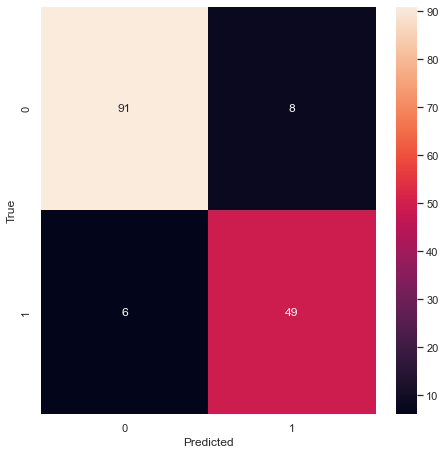

In [33]:
print(classification_report(ytest,ypred_lgbm))
cm_lgbm = confusion_matrix(ytest,ypred_lgbm)

plot_conf_matrix(cm_lgbm)

**Handling Imbalanced Dataset**

In [34]:
from imblearn.over_sampling import SMOTE

x=df.drop('Outcome',axis=1)
y=df['Outcome']
smote = SMOTE(sampling_strategy='minority')

x_smoote,y_smoote = smote.fit_resample(x,y)

print(f'\n\nSMOOTE shape of X : {x_smoote.shape}\nSMOOTE shape of Y : {y_smoote.shape}')
print(y_smoote.value_counts())

##Over-sampling



SMOOTE shape of X : (1000, 23)
SMOOTE shape of Y : (1000,)
0    500
1    500
Name: Outcome, dtype: int64


In [35]:
xtrain,xtest,ytrain,ytest = train_test_split(
    x_smoote,y_smoote,test_size=0.2,random_state=42,stratify=y_smoote
)

print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(800, 23) (800,)
(200, 23) (200,)


In [36]:
std_scaler = StandardScaler()
xtrain_scaled = std_scaler.fit_transform(xtrain)
xtest_scaled = std_scaler.transform(xtest)

In [37]:
cv_kfold = KFold(n_splits=10,shuffle=True,random_state=42)
svc_model = SVC()
svc_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel' : ['rbf']
            } 
svc_grid = GridSearchCV(svc_model,
                        svc_params,
                        cv=cv_kfold,
                        verbose=3,
                        n_jobs=-1,
                        refit=True
                        )

svc_grid.fit(xtrain_scaled,ytrain)

tuned_svc = SVC(
    C=svc_grid.best_params_['C'],
    gamma=svc_grid.best_params_['gamma'],
    kernel=svc_grid.best_params_['kernel']
).fit(xtrain_scaled,ytrain)

ypred_svc = tuned_svc.predict(xtest_scaled)
_svc_test_accuracy = accuracy_score(ytest,ypred_svc)
_svc_train_accuracy = accuracy_score(ytrain,tuned_svc.predict(xtrain_scaled))
print(_svc_test_accuracy,_svc_train_accuracy)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
0.825 0.95


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       100
           1       0.81      0.85      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



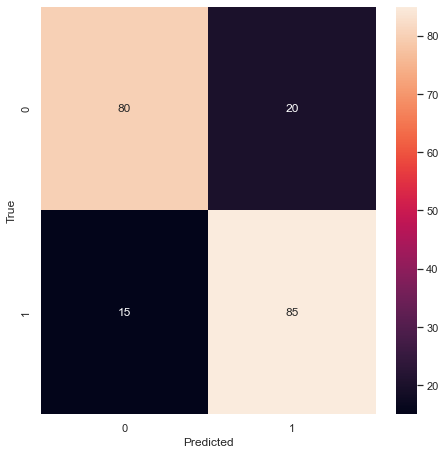

In [38]:
print(classification_report(ytest,ypred_svc))
cm_svc = confusion_matrix(ytest,ypred_svc)

plot_conf_matrix(cm_svc)



In [39]:
bagging_params = {
    'n_estimators':[200,500,700],
    'max_samples':[50,100]
}
bagging_model = BaggingClassifier(DecisionTreeClassifier(random_state=42))
bagging_grid = GridSearchCV(
    bagging_model,
    bagging_params,
    cv=cv_kfold,
    verbose=2,
    n_jobs=-1
)

bagging_grid.fit(xtrain_scaled,ytrain)

tuned_bagging = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=bagging_grid.best_params_['n_estimators'],
    max_samples=bagging_grid.best_params_['max_samples'],
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
    ).fit(xtrain_scaled,ytrain)

ypred_bag = tuned_bagging.predict(xtest_scaled)
_bag_test_accuracy = accuracy_score(ytest,ypred_bag)
_bag_train_accuracy = accuracy_score(ytrain,tuned_bagging.predict(xtrain_scaled))
print(_bag_test_accuracy,_bag_train_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.91 0.92


              precision    recall  f1-score   support

           0       0.93      0.89      0.91       100
           1       0.89      0.93      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



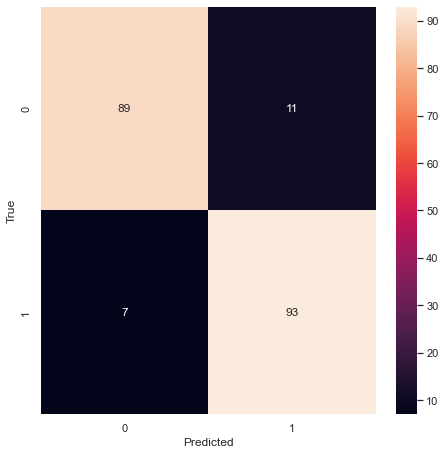

In [40]:
print(classification_report(ytest,ypred_bag))
cm_bag = confusion_matrix(ytest,ypred_bag)

plot_conf_matrix(cm_bag)

In [41]:
rf_params = { 
    'n_estimators': [200,500,700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv= cv_kfold,
    verbose=2,
    n_jobs=-1
    )


rf_grid.fit(xtrain_scaled,ytrain)

tuned_rf = RandomForestClassifier(
    n_estimators=rf_grid.best_params_['n_estimators'],
    max_features=rf_grid.best_params_['max_features'],
    oob_score=True,
    n_jobs=-1
).fit(xtrain_scaled,ytrain)

ypred_rf = tuned_rf.predict(xtest_scaled)
_rf_test_accuracy = accuracy_score(ytest,ypred_rf)
_rf_train_accuracy = accuracy_score(ytrain,tuned_rf.predict(xtrain_scaled))

print(_rf_test_accuracy,_rf_train_accuracy)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
0.905 1.0


              precision    recall  f1-score   support

           0       0.95      0.86      0.90       100
           1       0.87      0.95      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



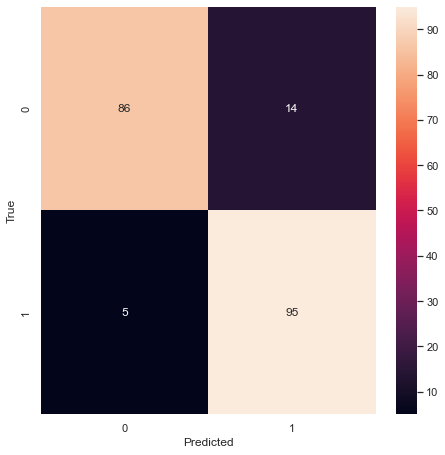

In [42]:
print(classification_report(ytest,ypred_rf))
cm_rf = confusion_matrix(ytest,ypred_rf)

plot_conf_matrix(cm_rf)

In [43]:
import lightgbm as lgbm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(x,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [3,4,5,6,7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
lgbm_grid = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

lgbm_grid.fit(x, y, **fit_params)
opt_parameters =  lgbm_grid.best_params_
tuned_lgbm = lgbm.LGBMClassifier(**opt_parameters).fit(xtrain,ytrain)

ypred_lgbm = tuned_lgbm.predict(xtest)
_lgbm_test_accuracy = accuracy_score(ytest,ypred_lgbm)
_lgbm_train_accuracy = accuracy_score(ytrain,tuned_lgbm.predict(xtrain))

print(_lgbm_test_accuracy,_lgbm_train_accuracy)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.91 0.925


              precision    recall  f1-score   support

           0       0.92      0.90      0.91       100
           1       0.90      0.92      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



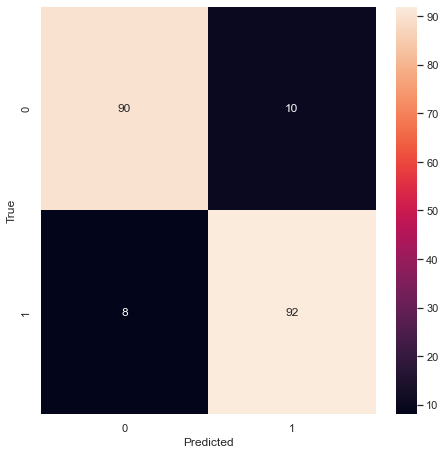

In [44]:
print(classification_report(ytest,ypred_lgbm))
cm_lgbm = confusion_matrix(ytest,ypred_lgbm)

plot_conf_matrix(cm_lgbm)

**Controling Overfitting**

In [45]:
result_df = pd.DataFrame({
    'train accuracies (before oversampling)':[svc_train_accuracy,bag_train_accuracy,rf_train_accuracy,lgbm_train_accuracy],
    'test accuracies (before oversampling)' :[svc_test_accuracy,bag_test_accuracy,rf_test_accuracy,lgbm_test_accuracy],
    'train accuracies (after oversampling)' : [_svc_train_accuracy,_bag_train_accuracy,_rf_train_accuracy,_lgbm_train_accuracy],
    'test accuracies (after oversampling)' : [_svc_test_accuracy,_bag_test_accuracy,_rf_test_accuracy,_lgbm_test_accuracy]
},index=['svc','bagging','rf','lgbm'])

In [46]:
result_df

,train accuracies (before oversampling),test accuracies (before oversampling),train accuracies (after oversampling),test accuracies (after oversampling)
svc,0.929967,0.792208,0.950,0.825
bagging,0.923453,0.915584,0.920,0.910
rf,1.000000,0.876623,1.000,0.905
lgbm,0.913681,0.909091,0.925,0.910


<AxesSubplot:>

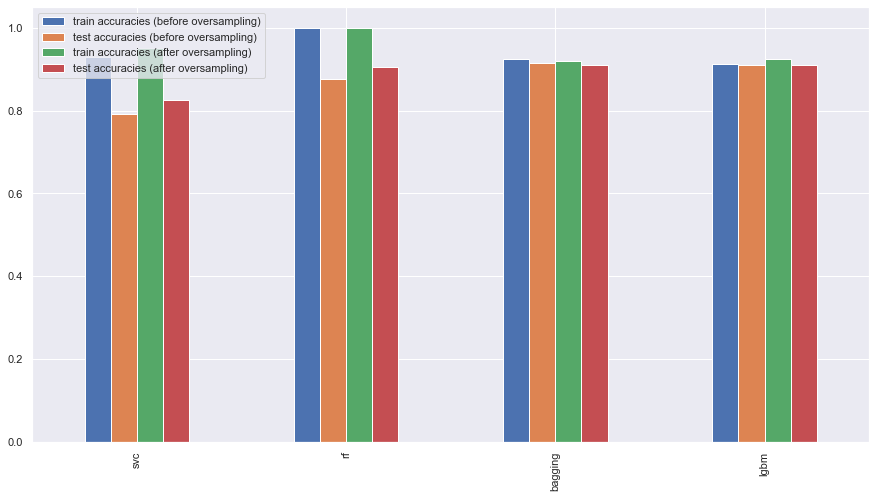

In [47]:
result_df.sort_values(by='test accuracies (after oversampling)').plot(kind='bar',figsize=(15,8))

In [51]:
import pickle

pickle.dump(tuned_lgbm,open('lgbm_diabetes_model.pkl','wb'))
pickle.dump(tuned_bagging,open('bagging_diabetes_model.pkl','wb'))
pickle.dump(std_scaler,open('std_scaler.pkl','wb'))
